# Parameterizing a Gaussian with a Neural Network<hr>

## Parameterizing a Gaussian
- Previously, we discussed how the encoder is going to output a distribution, rather than a value
- Can be confusing, so let's clear it up
- Some code to demonstrate


- Suppose out encoder has the sizes (4,3,2)
- Input dim. is 4
- Hidden dim. is 3
- Latent vector dim. is 2
- i.e. q(z) is a 2-D Gaussian
- We will use an axis-aligned Gaussian (one variance param per dimension), rather than a full covariance Gaussian (requires full DxD matrix)
- In other words, we can represent the variance with a single vector instead of a matrix with one element per to mention.


- How to accomplish this?
- Make the final layer size double what it is specified as
- E.g. 2-D Gaussian requires 4 numbers
- Use first 2 for mean, last 2 for variance / stddev, 
The first two components will represent the components of the mean and the second two components will represent the components of the standard deviation.
![parameterizing_gaussian](../images/parameterizing_gaussian.PNG)

## Problem
That's pretty simple but there is one more problem.<br>
Standard deviation must be a strictly positive number but a neural network can output anynumber positive or negative.

## Solution
- ### Softplus
a simeple solution is to use the soft plus activation function the soft plus is like a smooth version of the ReLU, it increases approximately linearly when the input is large and looks more like an exponential.<br>
**softplus(a) = log(1 + exp(a))**<br>
Most importantly it's smooth and continuous which means it's differentiable and it's *always bigger than zero.*

![softplus](../images/softplus.PNG)

So, now let's take a look at the code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

def softplus(x):
    # log1p(x) == log(1 + x)
    return np.log1p(np.exp(x))

# we're going to make a neural network
# with the layer sizes (4, 3, 2)
# like a toy version of a decoder 

W1 = np.random.randn(4, 3)
W2 = np.random.randn(3, 2*2)

# why 2 * 2?
# we need 2 components for the mean,
# and 2 componenets for the standard deviation !
# ignore bias terms for simplicity

def forward(x, W1, W2):
    hidden = np.tanh(x.dot(W1))
    output = hidden.dot(W2) # no activation !
    mean = output[:2]
    stddev = softplus(output[2:])
    return mean, stddev

The input size is 4, the hidden size is 3 and the output size is 2.<br>
We want the output size to be 2 so that we can plot the samples in a scatterplot<br>
Notice how the first weight is of size 4 by 3, but the second weight is of size 3 by 4 instead of 3 by 2<br>
This is because we need two outputs to represent the mean of the output distribution and two output to represent the standard deviation of the output distribution<br><br>
Next we have the forward function which does a standard feedforward pass through the neural network with a activation function<br>
Notice how at the end we split up the final outputs so that the first half represents the mean and the second half represents the standard deviation we then returned the mean and standard deviation.

x: [ 0.09819485  0.23121307  0.25866411 -0.07259684]
mean: [0.11004527 0.71400465]
stddev: [0.27229414 0.93393125]


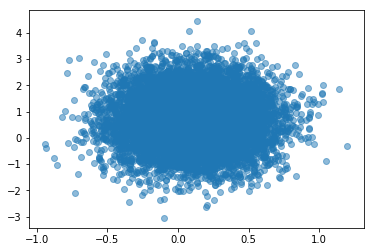

In [27]:
# make a random input
x = np.random.randn(4)

# get the parameters of the Gaussian
mean, stddev = forward(x, W1, W2)
print('x:',x)
print('mean:', mean)
print('stddev:',stddev)

# draw samples
samples = mvn.rvs(mean=mean, cov=stddev**2, size=10000)

# plot the samples
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.show()

Next we create a random input vector of size 4 and we pass this through the neural network to get the mean and standard deviation<br>
Remember **this represents sort of a model distribution q of z given x<br>**
Next we draw 10000 samples from a Gaussian with this mean and standard deviation.<br>
Note that the mvn module takes in a covariance which has variances along the diagonal, so we need to square the standard deviation.<br>
Finally once we have the samples we plot them on a scatterplot you can use this visual representation of the data to confirm that it has the mean and stadard deviation calculated by that neural network.

## Breakdown
- Code is simple, but conceptually different from what we usually do
- Output represents a distribution


1) Forward pass through neural net. Business as usual<br>
2) Output is not a value, but a distribution. This is different<br>
3) From this distribution, q(z), we will generate samples<br>
4) We haven't yet talked about how we'll train the weights of the encoder.<br>
Is it possible? z is a sample drawn down q(z), has no functional dependence on encoder weights

## Key point
- Encoder output distribution is a function of the input x
- q(z)
- We can call it \\(q(z | x)\\) to be more clear
- We can think of \\(q(z | x)\\) as the "true" conditional distribution of \\(z | x\\), and \\(q(z | x)\\) as our approximation of it
- Useful concept for when we discuss cost function